# How to Present Varying Metric Subsets

We want two different presentations of data:

1. A graph that has Kendall's tau on the y-axis and varying metric subsets on the x-axis, with the full dataset size kept constant, and a line for each dataset.
2. The same information (possibly not a graph this time... but maybe a series of graphs...?) but varying the total dataset size, and the metric subset sizes within that, looking again at the correlations.

In [770]:
from copy import deepcopy

import analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
import wandb
import yaml
from constants import DATASET_NAMES, MAX_SIZES, METRIC_NAMES

In [771]:
# Load the data
api = wandb.Api()
datasets = list(MAX_SIZES.keys())
train_data = utils.get_data(api, "train", datasets)
metric_data = utils.get_data(api, "metrics", datasets)
data = metric_data.merge(train_data, on=["dataset_name", "model_name", "n_samples"])

In [772]:
# Read in imagenet validation accuracies
with open("../configs/scores_imagenet1k.yaml") as f:
    imagenet = yaml.safe_load(f)
imagenet = [
    {"model_name": key, "imagenet-validation": {"score": imagenet[key]}}
    for key in imagenet.keys()
]
imagenet = pd.DataFrame(imagenet)

In [773]:
# Merge in imagenet val acc
data = data.merge(imagenet, on="model_name")

In [774]:
data["test_accuracy"] = data["test_accuracy"] * 100

In [775]:
# Compute all correlations accross different dataset sizes
group_data = data.groupby(["dataset_name", "n_samples", "n_metric_samples"])
metrics = ["renggli", "LogME", "n_pars", "imagenet-validation"]
tables = []
for met in metrics:
    tables.append(analysis.get_correlations(group_data, met))

KeyboardInterrupt: 

In [ ]:
copy_tables = deepcopy(tables)

In [20]:
# Extracting the data for plots
renggli_results = copy_tables[0]

In [ ]:
r_n_met_equal = renggli_results[
    renggli_results["n_samples"] == renggli_results["n_metric_samples"]
]

In [ ]:
# Extract dataset results:
d_res = []
for dataset_name in DATASET_NAMES.values():
    d_res.append(r_n_met_equal[r_n_met_equal["dataset"] == dataset_name])

In [ ]:
metric_names = {
    "renggli": "Renggli",
    "LogME": "LogME",
    "n_pars": "N. Params",
    "imagenet-validation": "ImageNet Acc.",
}

In [ ]:
# Pull out into a funcion


def plot_metric_result(
    ax, metric_result, metric, error_bars=False, xscale="log", ylim=(0.0, 1.0)
):
    """Plot the correlation per result for a single metric, in a single axis, for each
    dataset

    Args:
        ax: plt.ax from subplots on which to plot
        metric_result: dataframe of metric results
        metric: which metric is being looked at
        error_bars: plot error bars, default False
    """
    for dataset_name in DATASET_NAMES.values():
        dataset_result = metric_result[metric_result["dataset"] == dataset_name]
        # print(dataset_name)
        n_samples = dataset_result["n_samples"].values
        # print(n_samples)
        corrs = [v[0] for v in dataset_result[metric].values]
        # print(corrs)
        err = None
        if error_bars:
            err = np.asarray(
                [
                    [v[0] - v[1][0], v[1][1] - v[0]]
                    for v in dataset_result[metric].values
                ]
            ).T
        ax.errorbar(n_samples, corrs, yerr=err, label=dataset_name, marker="o")
        # ax.scatter(n_samples, corrs, label=dataset_name)
    ax.set_title(metric_names[metric], fontsize=15)
    ax.set_xlabel("Dataset Size", fontsize=12)
    ax.set_ylabel("Correlation", fontsize=12)
    ax.set_xscale(xscale)
    if metric == "renggli":
        ax.set_ylim = (-0.2, ylim[1])
    else:
        ax.set_ylim(ylim[0], ylim[1])

In [ ]:
# Function for all plots


def plot_all_metric_results(
    metric_results,
    metrics,
    error_bars=False,
    fig_size=(40, 10),
    xscale="log",
    ylim=(-0.2, 1.0),
):
    """Plot all of the correlation results varying by dataset size on a single multiplot

    Args:
        metric_results: _description_
        metrics: _description_
        error_bars: _description_. Defaults to False.
    """
    fig, ax = plt.subplots(1, 4, figsize=fig_size)
    for idx, metric in enumerate(metrics):
        metric_result = metric_results[idx][
            metric_results[idx]["n_samples"] == metric_results[idx]["n_metric_samples"]
        ]
        plot_metric_result(ax[idx], metric_result, metric, error_bars, xscale, ylim)
    fig.suptitle("Metric Correlations vs. Dataset Size", fontsize="20")
    handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    fig.legend(*zip(*unique), fontsize=15)

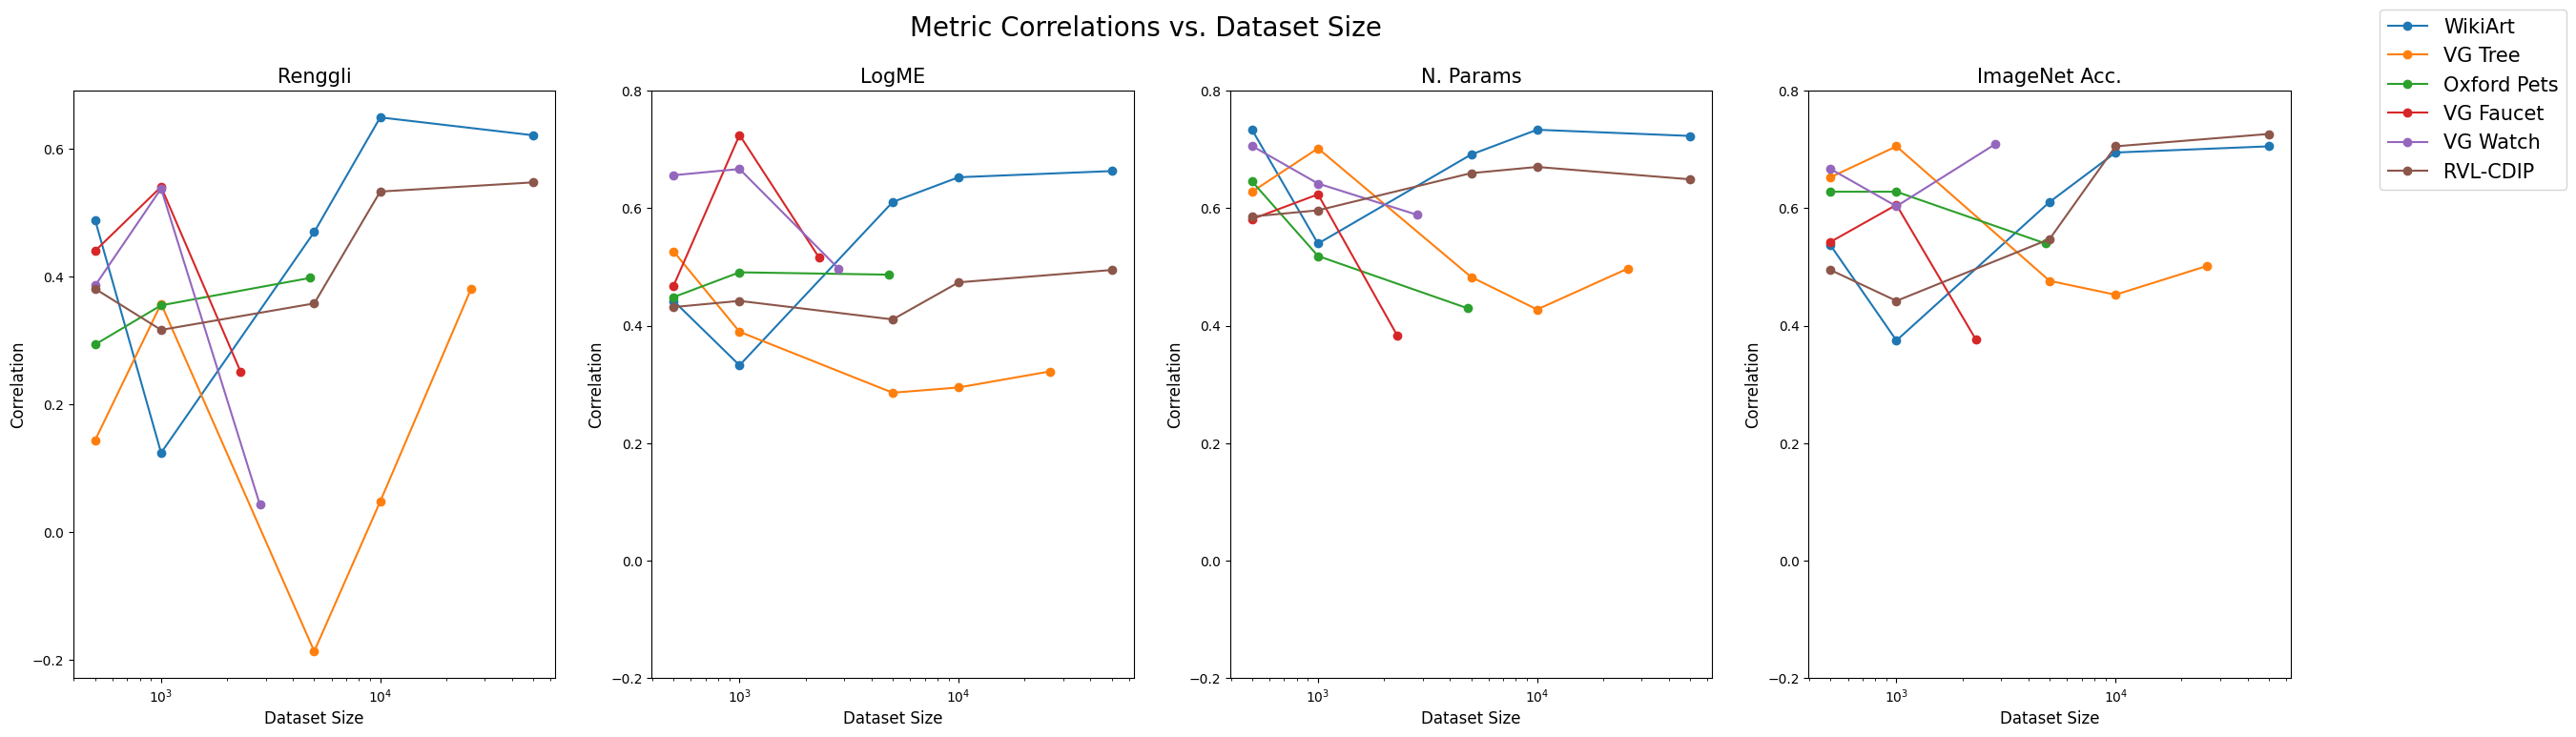

In [ ]:
plot_all_metric_results(
    tables, metrics, error_bars=False, xscale="log", ylim=(-0.2, 0.8), fig_size=(30, 8)
)

Also want to have plots with one dataset and metric per plot

In [ ]:
def plot_singles(
    metric_results,
    metrics,
    fig_size=(30, 30),
    errorbars=False,
    ylim=(0.0, 1.0),
    xscale="log",
):
    """Make plots for each combination of dataset and metric

    Args:
        metric_results: _description_
        metrics: _description_
        fig_size: _description_. Defaults to (30, 30).
    """
    fig, ax = plt.subplots(6, 4, figsize=fig_size)
    for idx, metric in enumerate(metrics.keys()):
        for jdx, dataset_name in enumerate(DATASET_NAMES.values()):
            metric_result = metric_results[idx][
                metric_results[idx]["n_samples"]
                == metric_results[idx]["n_metric_samples"]
            ]
            dataset_result = metric_result[metric_result["dataset"] == dataset_name]
            n_samples = dataset_result["n_samples"].values
            corrs = [v[0] for v in dataset_result[metric].values]
            err = None
            if errorbars:
                err = np.asarray(
                    [
                        [v[0] - v[1][0], v[1][1] - v[0]]
                        for v in dataset_result[metric].values
                    ]
                ).T
            ax[jdx, idx].errorbar(
                n_samples, corrs, yerr=err, label=dataset_name, marker="o"
            )
            ax[jdx, idx].set_title(
                f"{metric_names[metric]} Correlation vs. {dataset_name}", fontsize=15
            )
            ax[jdx, idx].set_xlabel("Dataset Size", fontsize=12)
            ax[jdx, idx].set_ylabel("Correlation", fontsize=12)
            ax[jdx, idx].set_xscale(xscale)
            ax[jdx, idx].set_ylim(-0.2, 1.0)
            # if metric == "renggli":
            #     ax[jdx, idx].set_ylim = (-0.2, ylim[1])
            # else:
            #     ax[jdx, idx].set_ylim(ylim[0], ylim[1])
    # fig.suptitle("Metric Correlations vs. Dataset Size", fontsize="20")
    # handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    # handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    # unique = [
    #     (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    # ]
    # fig.legend(*zip(*unique), fontsize=15)
    fig.tight_layout()

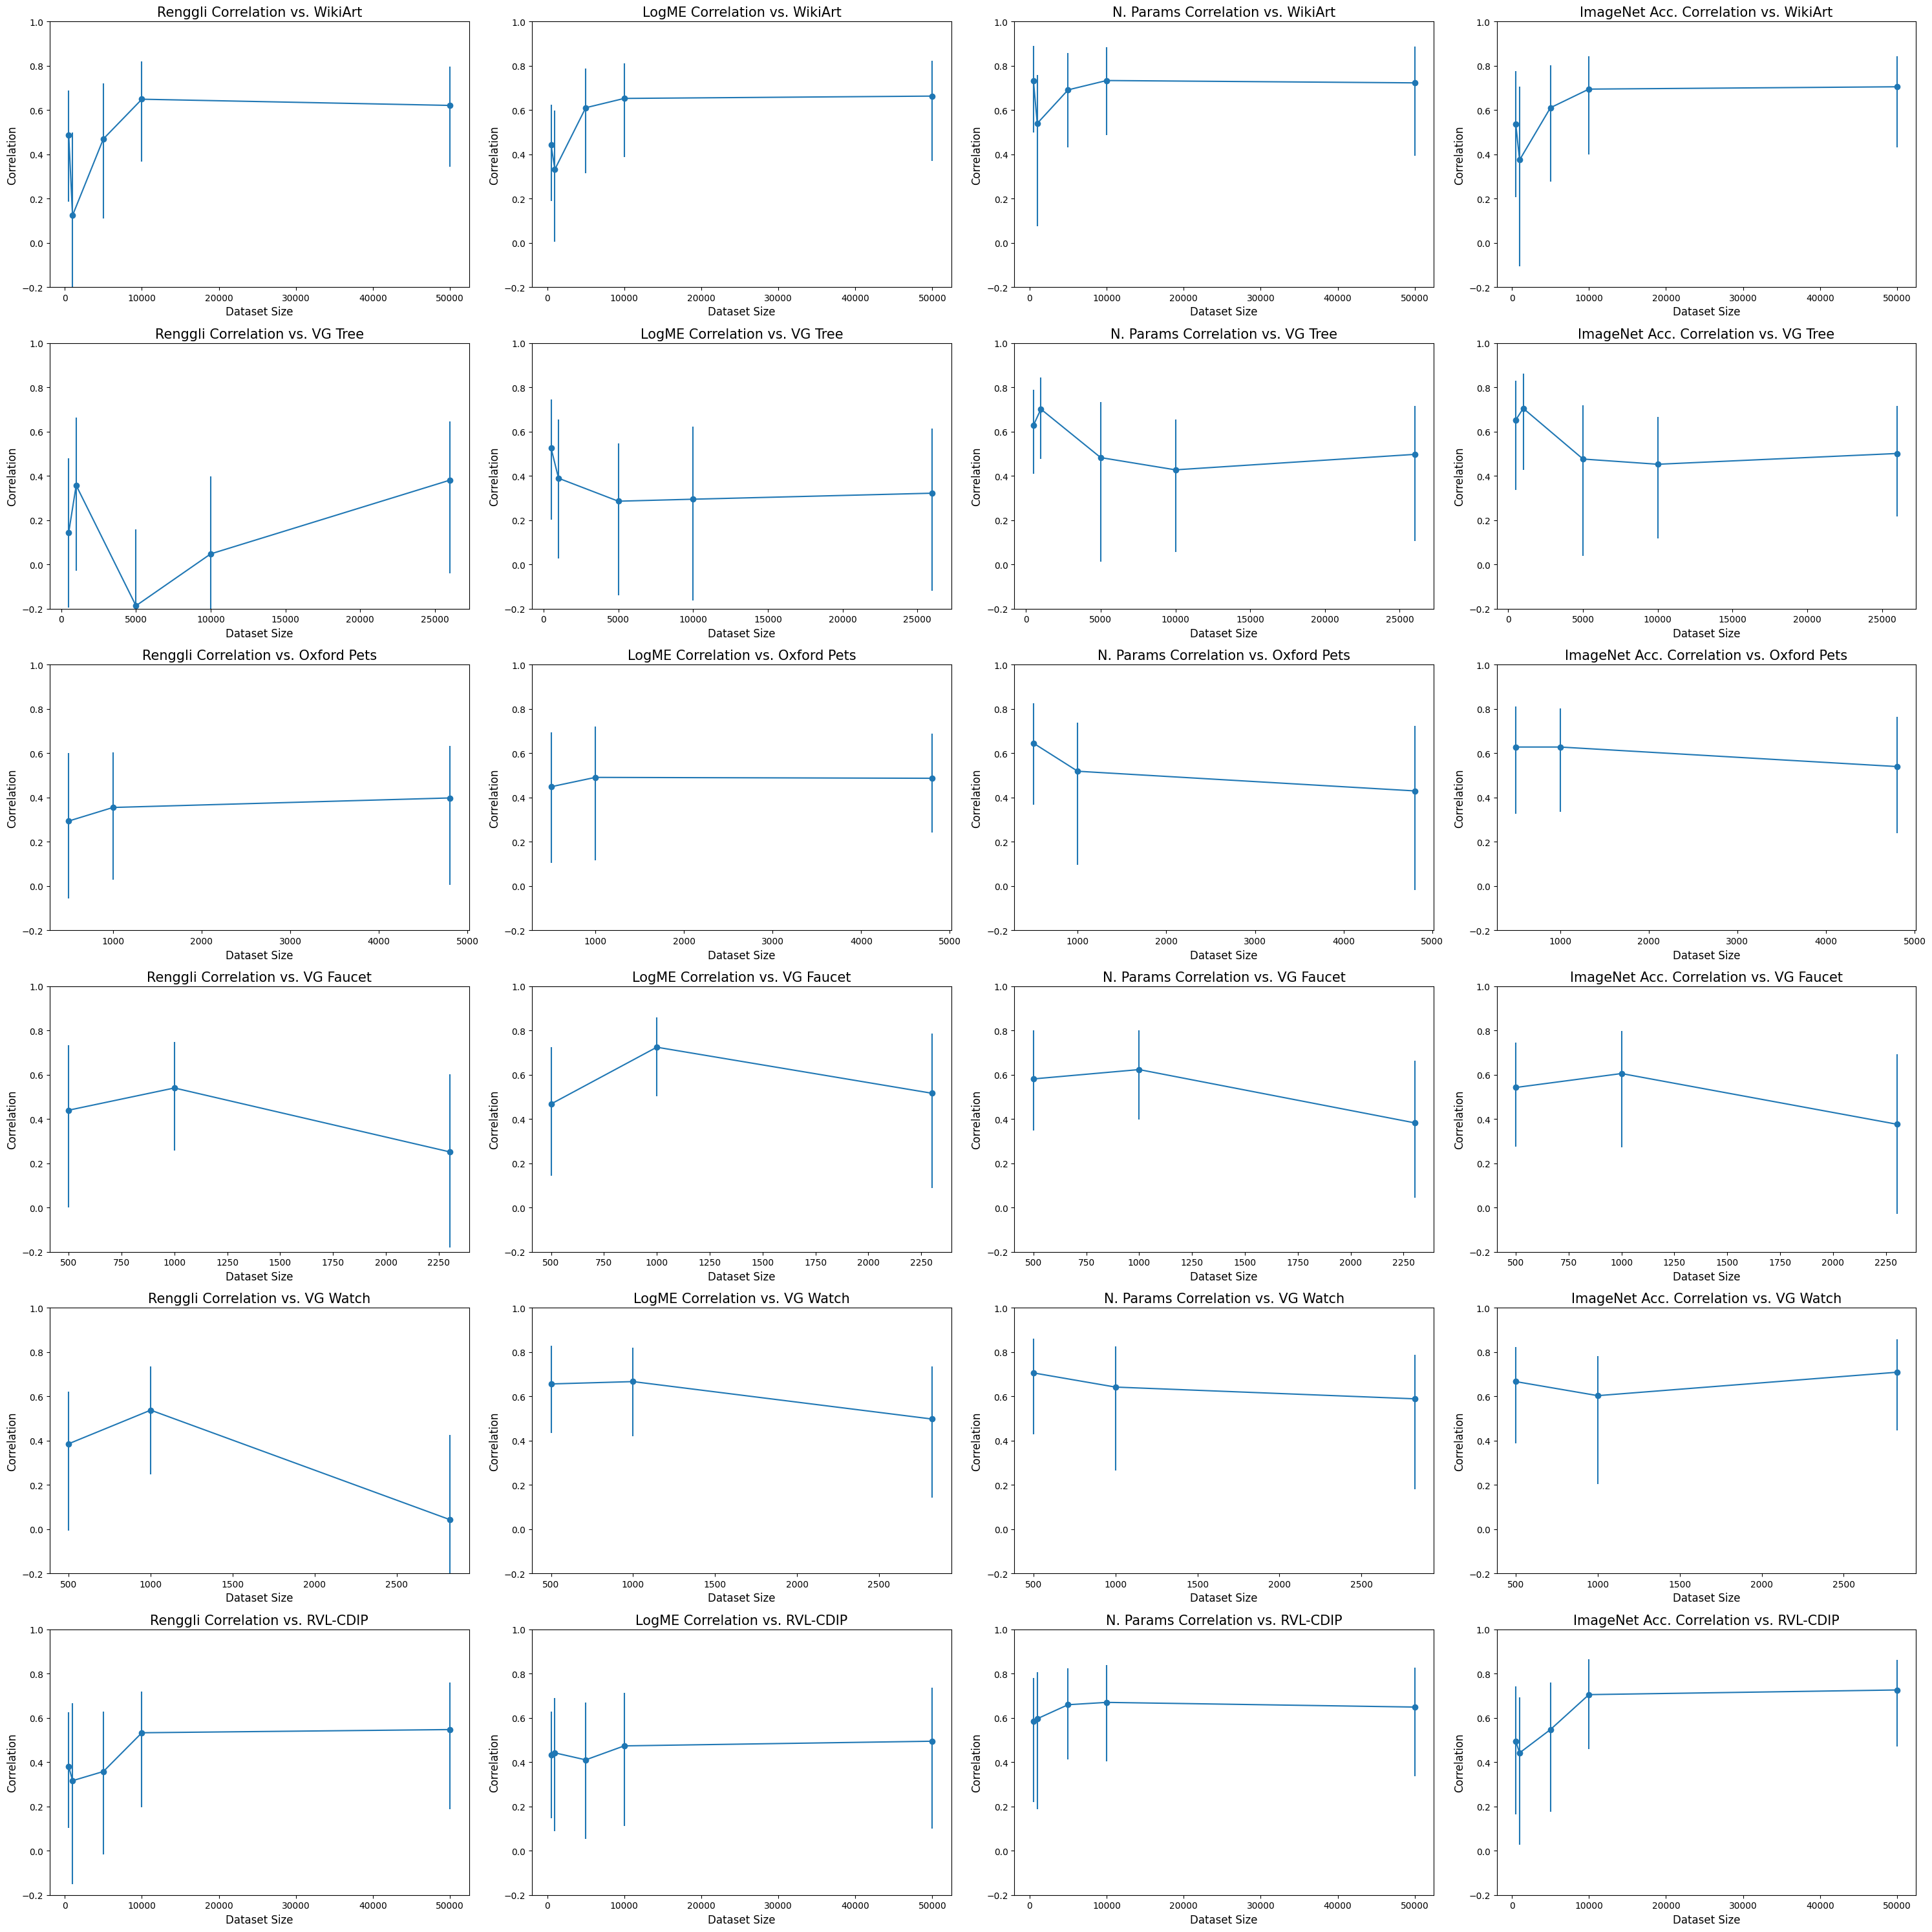

In [ ]:
plot_singles(tables, metric_names, xscale="linear", errorbars=True)

### How much to metric performance decrease when metric samples are a subset of the total dataset size?

I think a first pass at visualising this would be to create a top level version similar to the above plot, and a bigger version where the dataset size is varied as well.

In [ ]:
# Pull out into a funcion


def plot_metric_subset_result(
    ax, metric_result, metric, error_bars=False, xscale="log", ylim=(0.0, 1.0)
):
    """Plot the correlation per result for a single metric, in a single axis, for each
    dataset

    Args:
        ax: plt.ax from subplots on which to plot
        metric_result: dataframe of metric results
        metric: which metric is being looked at
        error_bars: plot error bars, default False
    """
    for dataset_name in DATASET_NAMES.values():
        dataset_result = metric_result[metric_result["dataset"] == dataset_name]
        # print(dataset_name)
        n_samples = dataset_result["n_metric_samples"].values
        # print(n_samples)
        corrs = [v[0] for v in dataset_result[metric].values]
        # print(corrs)
        err = None
        if error_bars:
            err = np.asarray(
                [
                    [v[0] - v[1][0], v[1][1] - v[0]]
                    for v in dataset_result[metric].values
                ]
            ).T
        ax.errorbar(n_samples, corrs, yerr=err, label=dataset_name, marker="o")
        # ax.scatter(n_samples, corrs, label=dataset_name)
    ax.set_title(metric_names[metric], fontsize=15)
    ax.set_xlabel("Metric Computation Datset Subset Size", fontsize=12)
    ax.set_ylabel("Correlation", fontsize=12)
    ax.set_xscale(xscale)
    if metric == "renggli":
        ax.set_ylim = (-0.2, ylim[1])
    else:
        ax.set_ylim(ylim[0], ylim[1])

In [ ]:
# Function for all plots


def plot_constant_top_samples(
    metric_results,
    metrics,
    error_bars=False,
    fig_size=(40, 10),
    xscale="log",
    ylim=(-0.2, 1.0),
):
    """Plot all of the correlation results varying by dataset size on a single multiplot

    Args:
        metric_results: _description_
        metrics: _description_
        error_bars: _description_. Defaults to False.
    """
    fig, ax = plt.subplots(1, 2, figsize=fig_size)
    for idx, metric in enumerate(metrics):
        if metric == "n_pars":
            continue
        if metric == "imagenet-validation":
            continue
        metric_result = metric_results[idx][
            metric_results[idx]["n_samples"].isin(MAX_SIZES.values())
        ]
        plot_metric_subset_result(
            ax[idx], metric_result, metric, error_bars, xscale, ylim
        )
    fig.suptitle(
        "Metric Correlations vs. Metric Computation Subset Size", fontsize="20"
    )
    handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    fig.legend(*zip(*unique), fontsize=15, loc="center right")

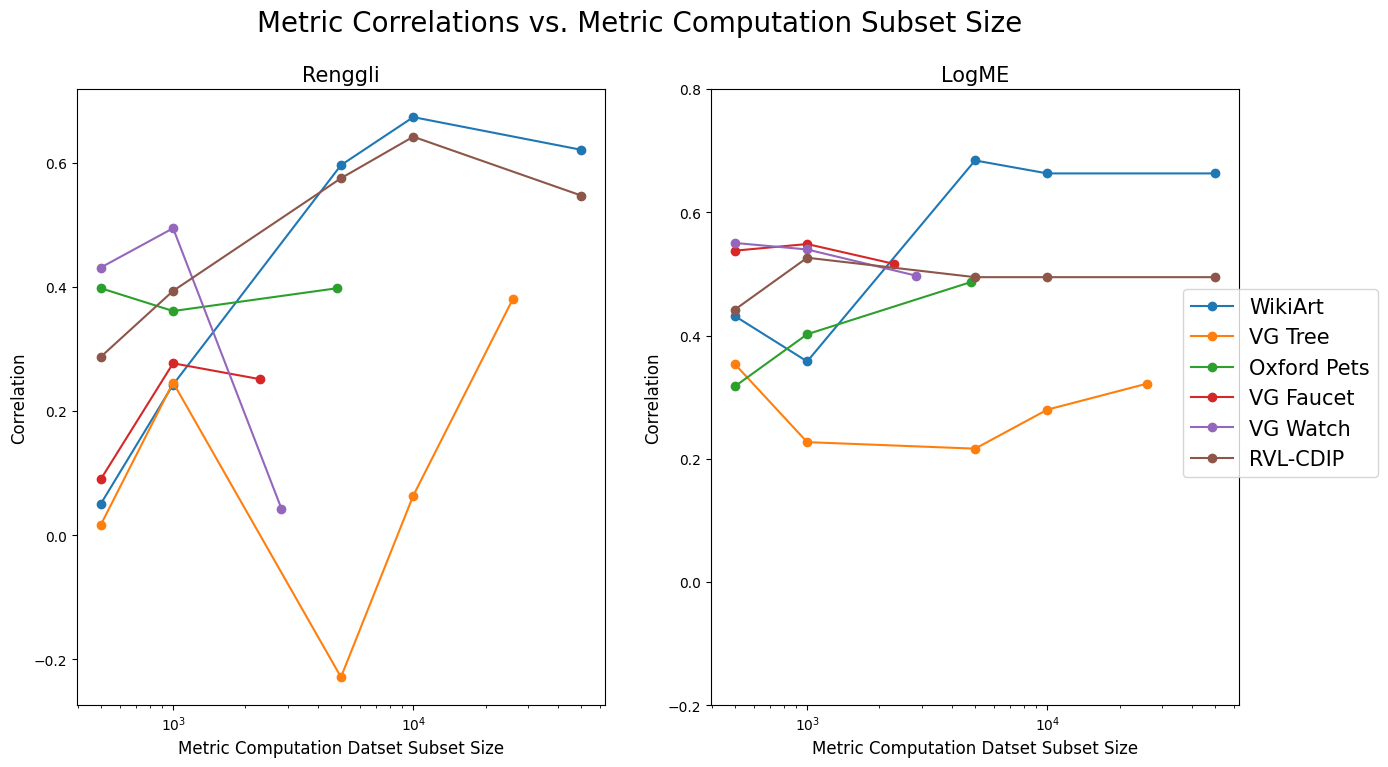

In [ ]:
plot_constant_top_samples(
    tables, metrics, error_bars=False, xscale="log", ylim=(-0.2, 0.8), fig_size=(15, 8)
)

In [ ]:
test = deepcopy(tables[0])

In [ ]:
dataset_samples = [500, 1000, 5000, 10000, "max"]

In [ ]:
def plot_subset_singles(
    metric_results,
    metrics,
    fig_size=(30, 30),
    errorbars=False,
    ylim=(0.0, 1.0),
    xscale="log",
):
    """make plots for all combinations

    Args:
        metric_results: _description_
        metrics: _description_
        fig_size: _description_. Defaults to (30, 30).
        errorbars: _description_. Defaults to False.
        ylim: _description_. Defaults to (0.0, 1.0).
        xscale: _description_. Defaults to "log".
    """
    fig, ax = plt.subplots(5, 2, figsize=fig_size)
    for jdx, metric in enumerate(metrics.keys()):
        if metric == "n_pars":
            continue
        if metric == "imagenet-validation":
            continue
        # print(f"{metric}-----------------------------------------")
        for idx, dataset_sample in enumerate(dataset_samples):
            # print(f"{dataset_sample}------------------------------------")
            if dataset_sample == "max":
                metric_result = metric_results[jdx][
                    metric_results[jdx]["n_samples"].isin(MAX_SIZES.values())
                ]
                data
            else:
                metric_result = metric_results[jdx][
                    metric_results[jdx]["n_samples"] == dataset_sample
                ]
            for dataset_name in DATASET_NAMES.values():
                # print(f'{dataset_name}')
                dataset_result = metric_result[metric_result["dataset"] == dataset_name]
                # print(dataset_result)
                n_samples = dataset_result["n_metric_samples"].values
                # print(n_samples)
                corrs = [v[0] for v in dataset_result[metric].values]
                err = None
                if errorbars:
                    err = np.asarray(
                        [
                            [v[0] - v[1][0], v[1][1] - v[0]]
                            for v in dataset_result[metric].values
                        ]
                    ).T
                ax[idx, jdx].errorbar(
                    n_samples, corrs, yerr=err, label=dataset_name, marker="o"
                )
                ax[idx, jdx].set_title(
                    f"{metric_names[metric]}, Dataset size {dataset_sample}"
                )
                ax[idx, jdx].set_xlabel("Dataset Size", fontsize=12)
                ax[idx, jdx].set_ylabel("Correlation", fontsize=12)
                ax[idx, jdx].set_xscale(xscale)
                ax[idx, jdx].set_ylim(-0.3, 1.0)
    fig.suptitle(
        "Metric Correlations vs. Metric Subset Size per Dataset Size", fontsize="20"
    )
    handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    fig.legend(*zip(*unique), fontsize=15)

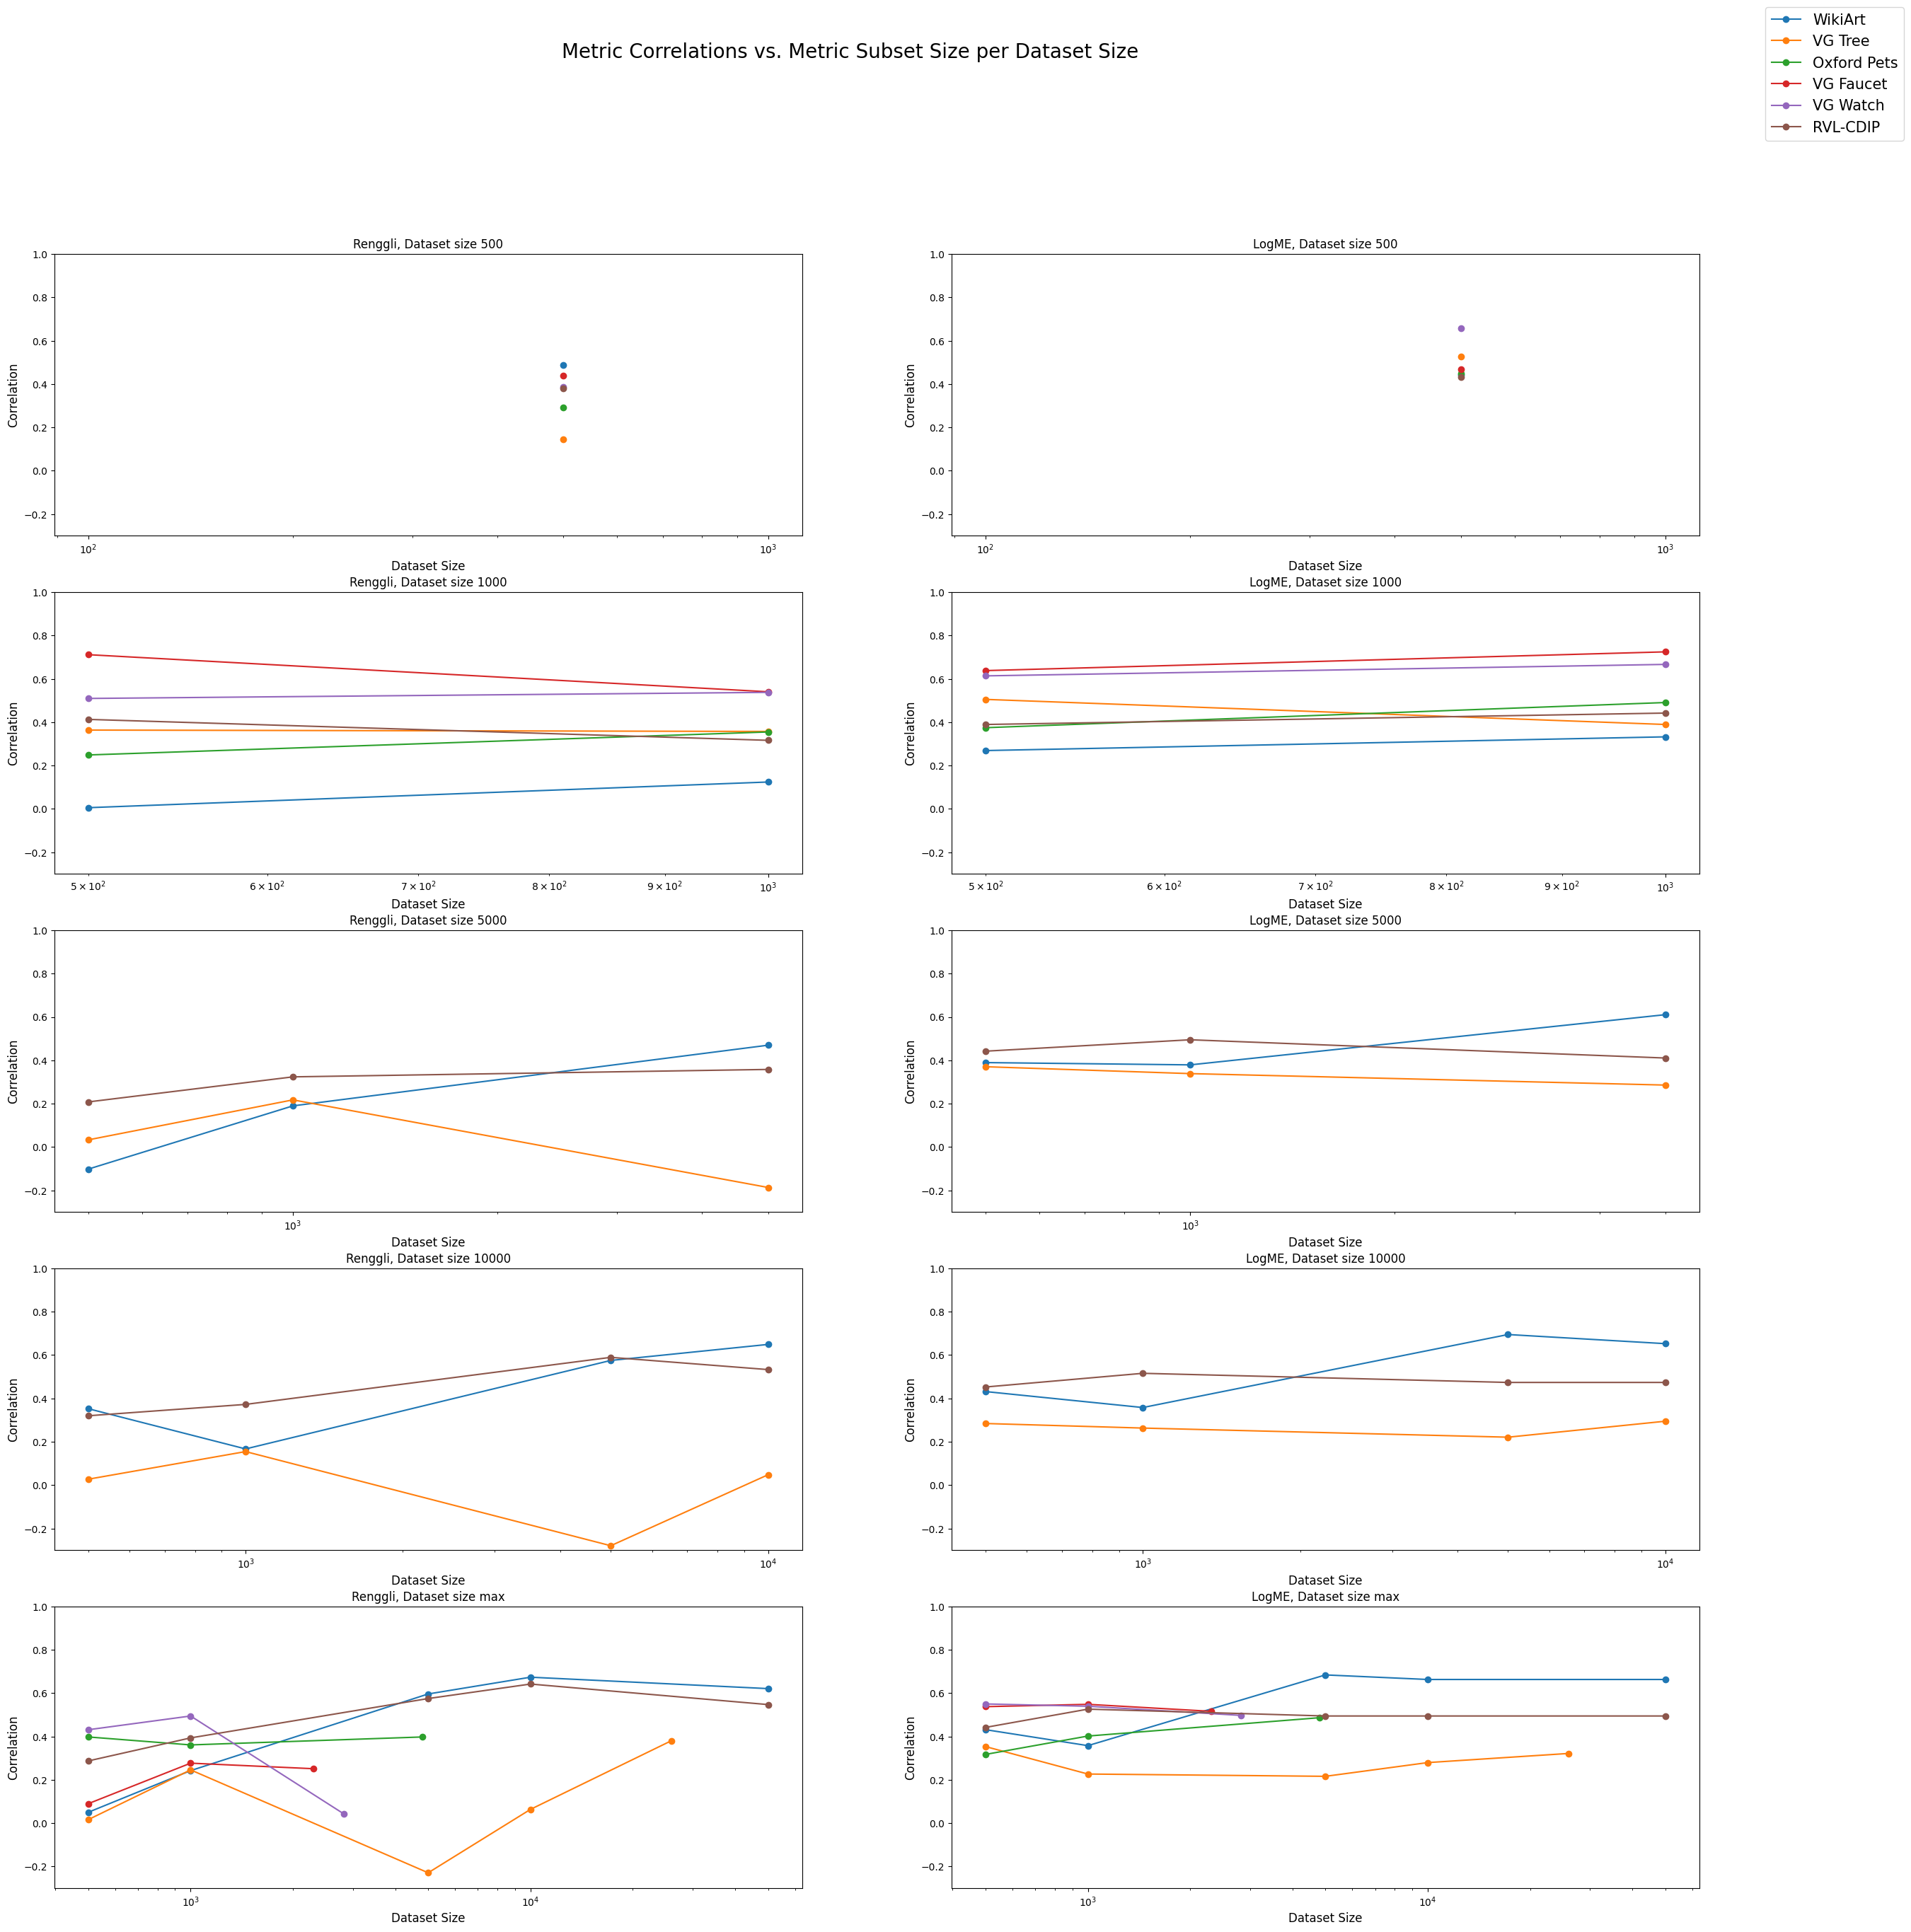

In [ ]:
plot_subset_singles(tables, metric_names, xscale="log")

## Regret on Y

Recreating several of the above tables with regret on the y axis

In [ ]:
# Loaded in data from the top, now group and compute regrets
group_data = data.groupby(["dataset_name", "n_samples", "n_metric_samples"])

In [ ]:
regret_tables = []
for metric in METRIC_NAMES:
    regret_tables.append(analysis.get_regrets(group_data, metric, 1))

In [ ]:
def plot_metric_regret(
    ax, metric_result, metric, error_bars=False, xscale="log", ylim=(0.0, 1.0)
):
    """Plot the correlation per result for a single metric, in a single axis, for each
    dataset

    Args:
        ax: plt.ax from subplots on which to plot
        metric_result: dataframe of metric results
        metric: which metric is being looked at
        error_bars: plot error bars, default False
    """
    for dataset_name in DATASET_NAMES.values():
        dataset_result = metric_result[metric_result["dataset"] == dataset_name]
        # print(dataset_name)
        n_samples = dataset_result["n_samples"].values
        # print(n_samples)
        corrs = dataset_result[metric].values
        # print(corrs)
        err = None
        if error_bars:
            err = np.asarray(
                [
                    [v[0] - v[1][0], v[1][1] - v[0]]
                    for v in dataset_result[metric].values
                ]
            ).T
        ax.errorbar(n_samples, corrs, yerr=err, label=dataset_name, marker="o")
        # ax.scatter(n_samples, corrs, label=dataset_name)
    ax.set_title(metric_names[metric][0], fontsize=15)
    ax.set_xlabel("Dataset Size", fontsize=12)
    ax.set_ylabel("Regret", fontsize=12)
    ax.set_xscale(xscale)
    ax.set_ylim(ylim[0], ylim[1])

In [ ]:
def plot_all_metric_regret(
    metric_results,
    metrics,
    error_bars=False,
    fig_size=(40, 10),
    xscale="log",
    ylim=(-0.2, 1.0),
):
    """Plot all of the correlation results varying by dataset size on a single multiplot

    Args:
        metric_results: _description_
        metrics: _description_
        error_bars: _description_. Defaults to False.
    """
    fig, ax = plt.subplots(1, 4, figsize=fig_size)
    for idx, metric in enumerate(METRIC_NAMES):
        metric_result = metric_results[idx][
            metric_results[idx]["n_samples"] == metric_results[idx]["n_metric_samples"]
        ]
        plot_metric_regret(ax[idx], metric_result, metric, error_bars, xscale, ylim)
    fig.suptitle("Metric Regret vs. Dataset Size", fontsize="20")
    handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    unique = [
        (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    ]
    fig.legend(*zip(*unique), fontsize=15)

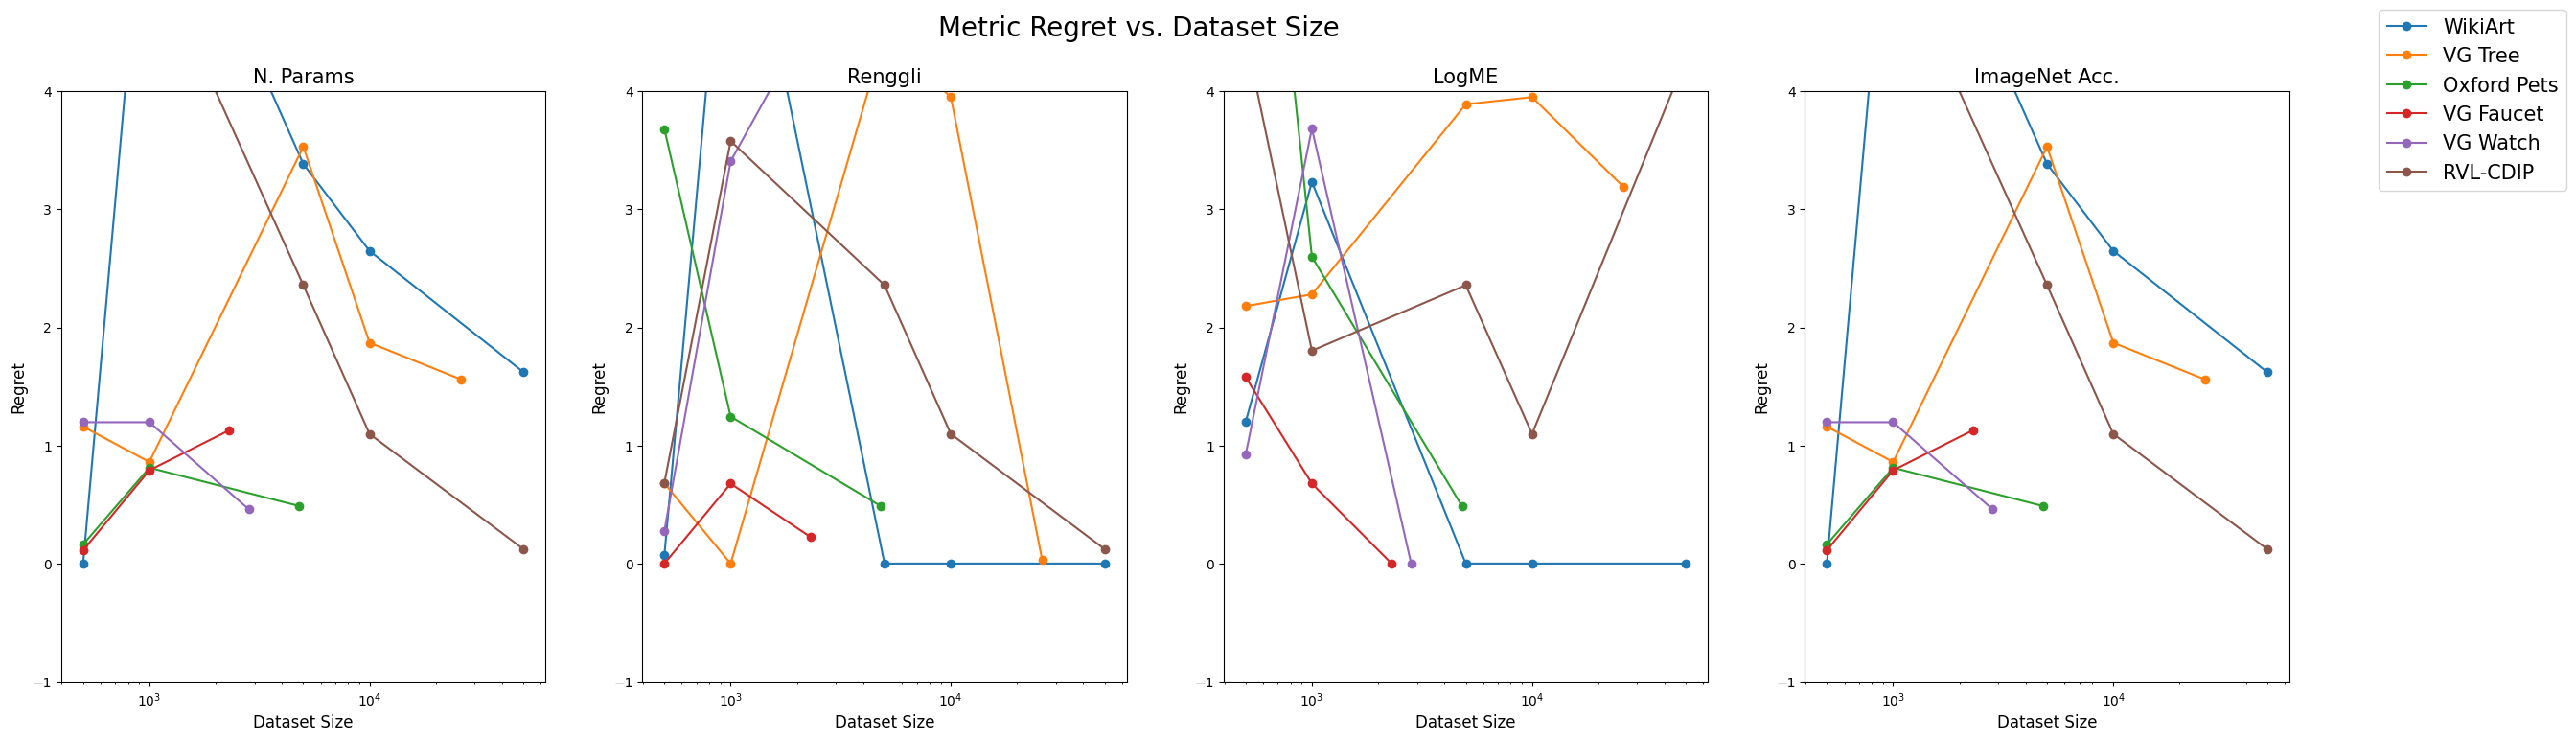

In [ ]:
plot_all_metric_regret(
    regret_tables,
    metrics,
    error_bars=False,
    xscale="log",
    ylim=(-1.0, 4),
    fig_size=(30, 8),
)

In [ ]:
def plot_single_regret(
    metric_results,
    metrics,
    fig_size=(30, 30),
    errorbars=False,
    ylim=(0.0, 1.0),
    xscale="log",
):
    """Make plots for each combination of dataset and metric

    Args:
        metric_results: _description_
        metrics: _description_
        fig_size: _description_. Defaults to (30, 30).
    """
    fig, ax = plt.subplots(6, 4, figsize=fig_size)
    for idx, metric in enumerate(METRIC_NAMES):
        for jdx, dataset_name in enumerate(DATASET_NAMES.values()):
            metric_result = metric_results[idx][
                metric_results[idx]["n_samples"]
                == metric_results[idx]["n_metric_samples"]
            ]
            dataset_result = metric_result[metric_result["dataset"] == dataset_name]
            n_samples = dataset_result["n_samples"].values
            corrs = dataset_result[metric].values
            err = None
            if errorbars:
                err = np.asarray(
                    [
                        [v[0] - v[1][0], v[1][1] - v[0]]
                        for v in dataset_result[metric].values
                    ]
                ).T
            ax[jdx, idx].errorbar(
                n_samples, corrs, yerr=err, label=dataset_name, marker="o"
            )
            ax[jdx, idx].set_title(
                f"{metric_names[metric][0]} Regret vs. {dataset_name}", fontsize=15
            )
            ax[jdx, idx].set_xlabel("Dataset Size", fontsize=12)
            ax[jdx, idx].set_ylabel("Regret", fontsize=12)
            ax[jdx, idx].set_xscale(xscale)
            ax[jdx, idx].set_ylim(-0.1, 2.2)
            # if metric == "renggli":
            #     ax[jdx, idx].set_ylim = (-0.2, ylim[1])
            # else:
            #     ax[jdx, idx].set_ylim(ylim[0], ylim[1])
    # fig.suptitle("Metric Correlations vs. Dataset Size", fontsize="20")
    # handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    # handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
    # unique = [
    #     (h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]
    # ]
    # fig.legend(*zip(*unique), fontsize=15)
    fig.tight_layout()

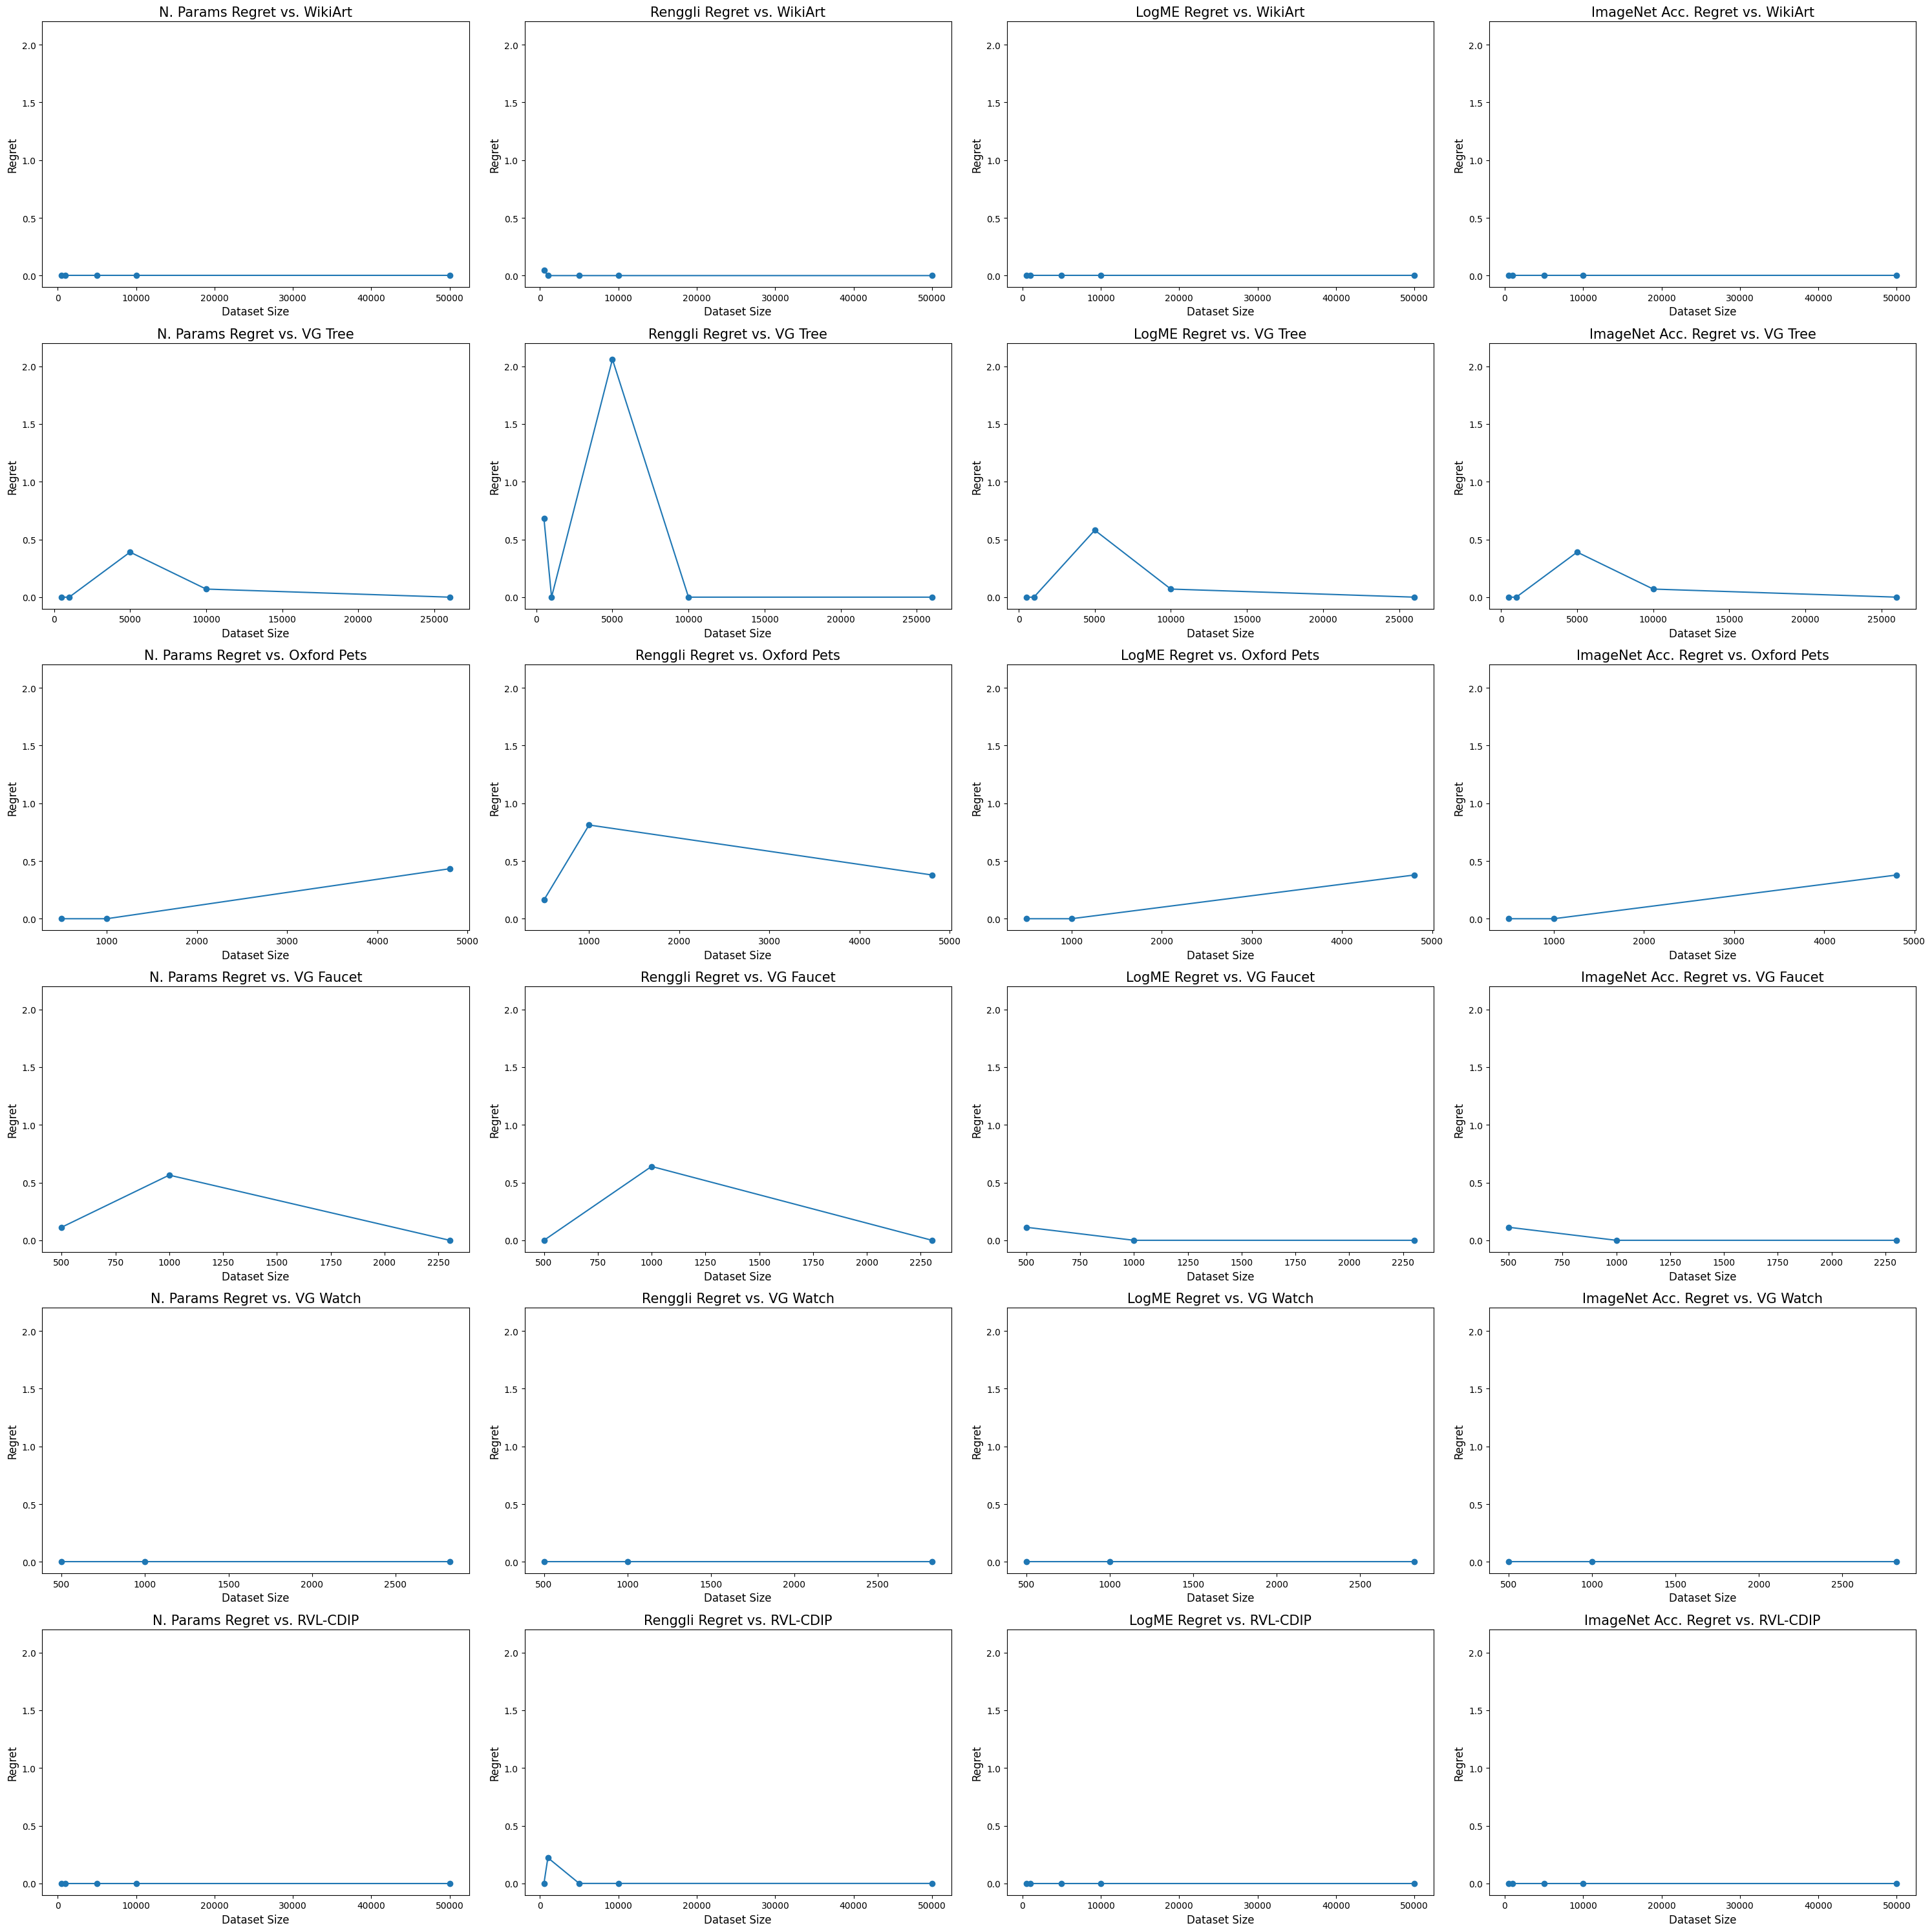

In [ ]:
plot_single_regret(regret_tables, metric_names, xscale="linear", errorbars=False)

## Raw Values vs. Metric Subset Size

In [ ]:
top_data = data[data["n_samples"].isin(MAX_SIZES.values())]

In [ ]:
metric_names

{'renggli': ('Renggli', 0),
 'LogME': ('LogME', 1),
 'n_pars': ('N. Params', 2),
 'imagenet-validation': ('ImageNet Acc.', 3)}

In [ ]:
DATASET_NAMES

{'huggan/wikiart': 'WikiArt',
 '/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMoSeT/binary_datasets/bin_tree': 'VG Tree',
 'pcuenq/oxford-pets': 'Oxford Pets',
 '/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMoSeT/binary_datasets/bin_faucet': 'VG Faucet',
 '/bask/projects/v/vjgo8416-locomoset/ARC-LoCoMoSeT/binary_datasets/bin_watch': 'VG Watch',
 'aharley/rvl_cdip': 'RVL-CDIP'}

In [ ]:
print(list(DATASET_NAMES.keys())[2])
np.unique(
    top_data[(top_data["dataset_name"] == list(DATASET_NAMES.keys())[2])][
        "n_metric_samples"
    ].values
)

pcuenq/oxford-pets


array([ 500, 1000, 4803])

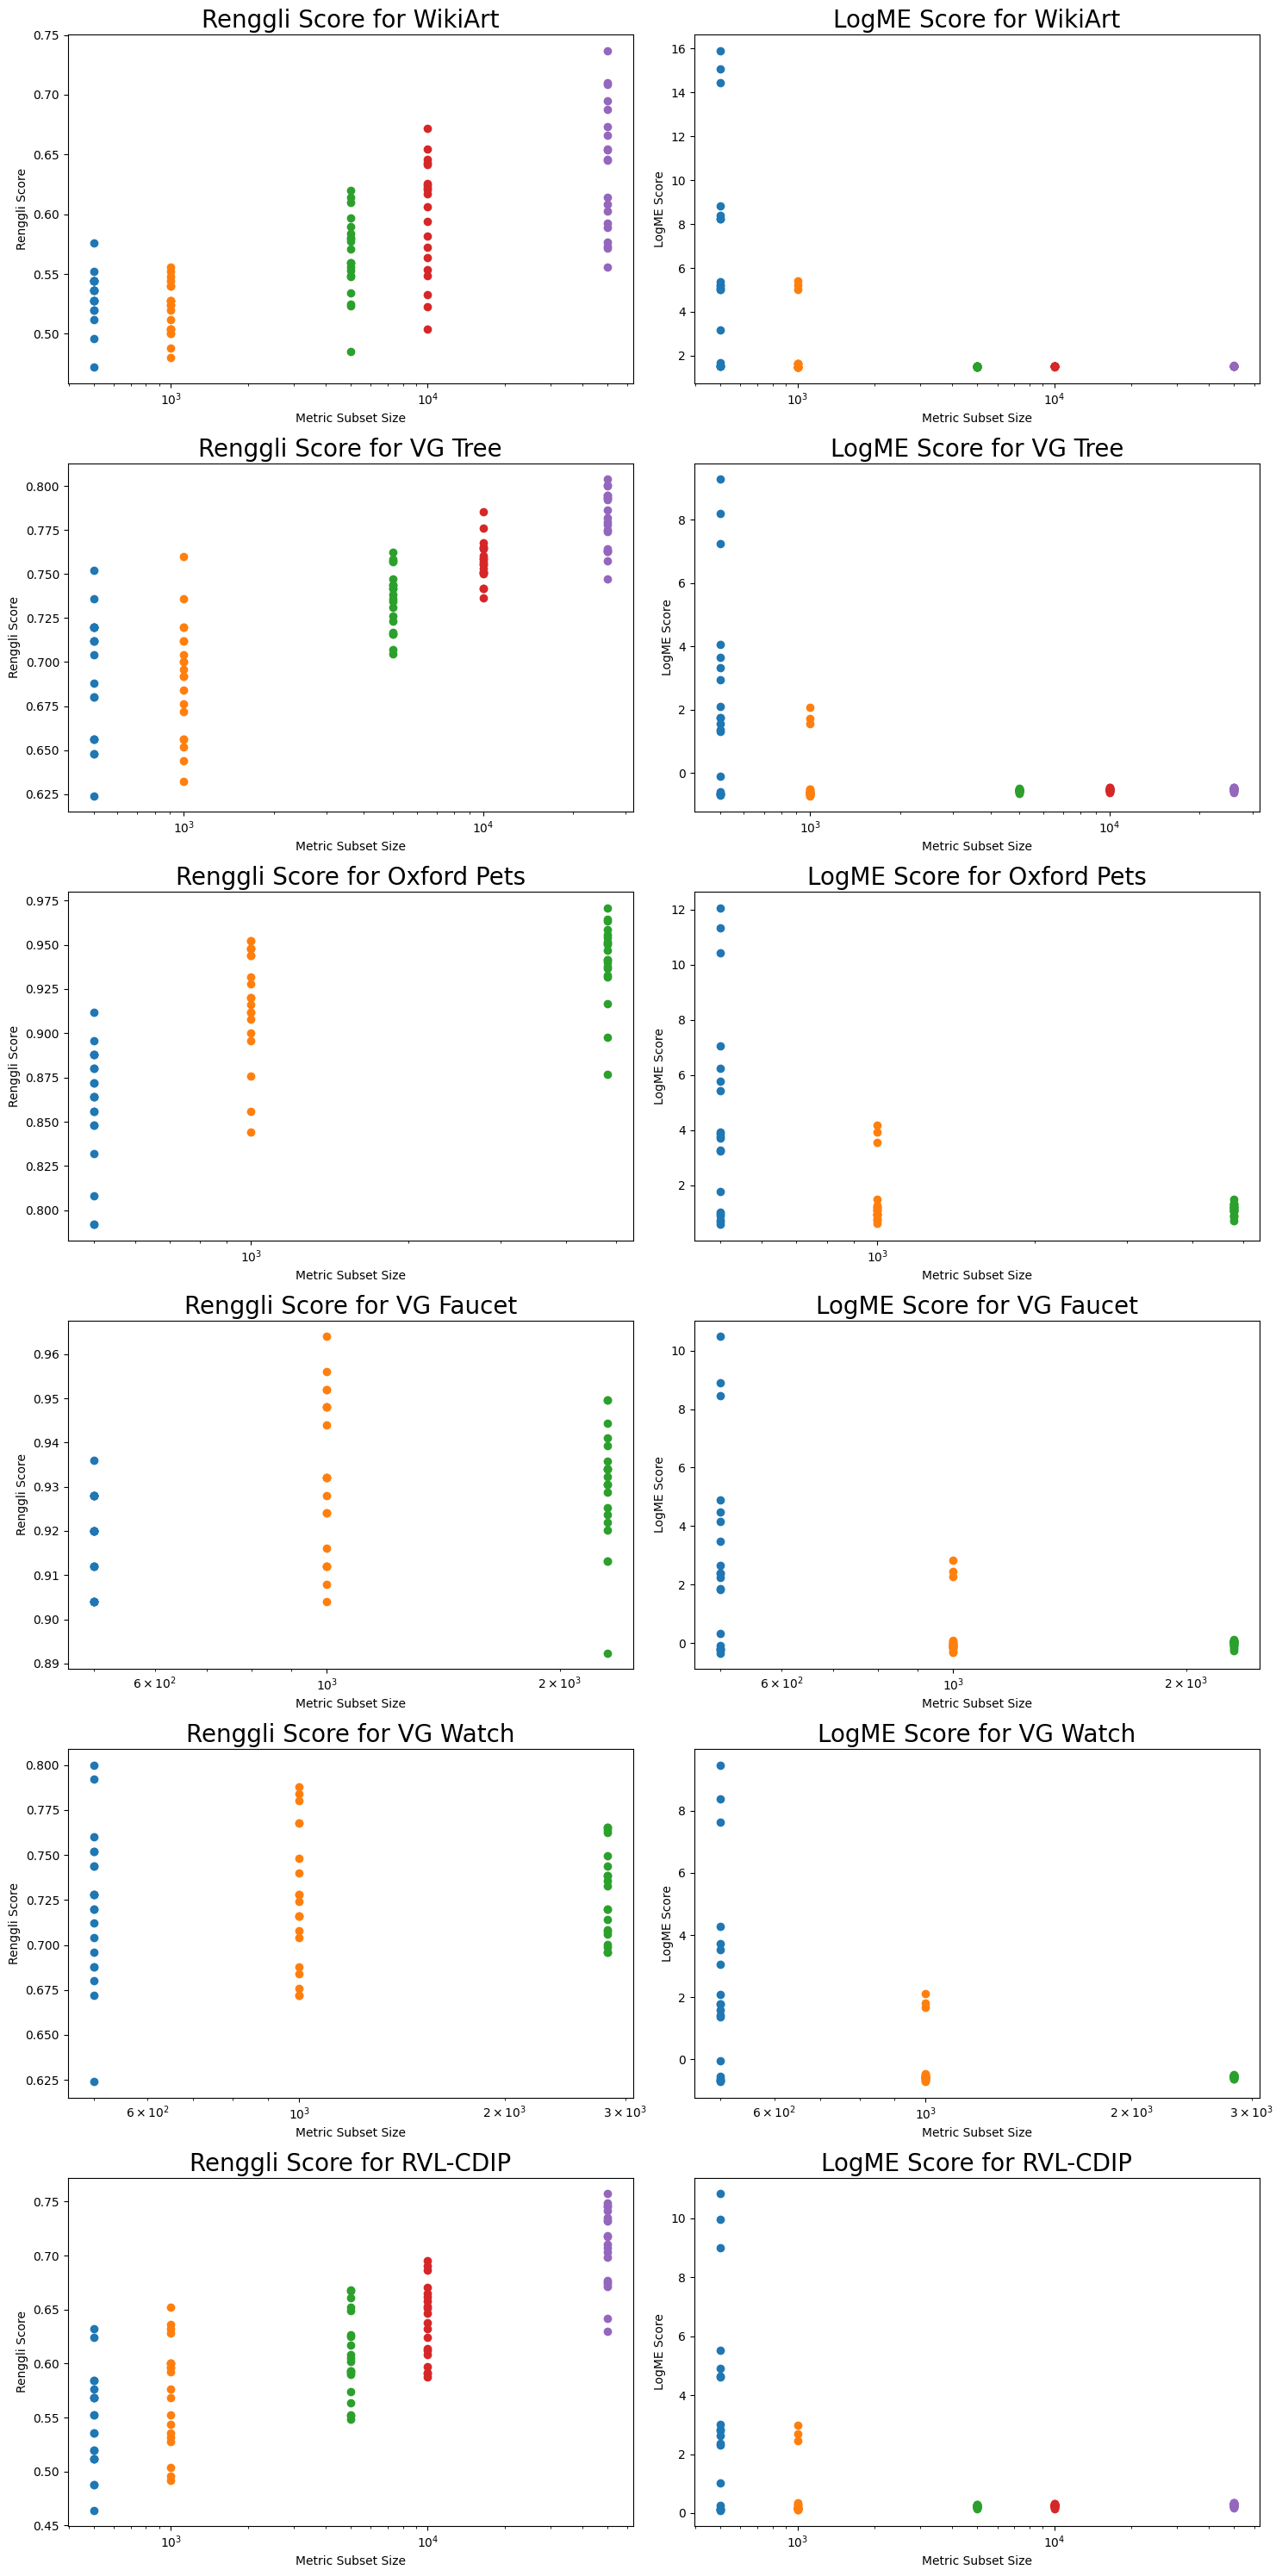

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(15, 30))
# fig.suptitle("Metric Scores vs. Metric Subset Size", fontsize=25)
for jdx, metric in enumerate(metric_names.keys()):
    if metric == "n_pars":
        continue
    if metric == "imagenet-validation":
        continue
    for idx, dataset in enumerate(DATASET_NAMES.keys()):
        ax[idx, jdx].set_title(
            f"{metric_names[metric][0]} Score for {DATASET_NAMES[dataset]}", fontsize=20
        )
        met_subsets = np.unique(
            top_data[top_data["dataset_name"] == dataset]["n_metric_samples"].values
        )
        ax[idx, jdx].set_xscale("log")
        ax[idx, jdx].set_xlabel("Metric Subset Size")
        ax[idx, jdx].set_ylabel(f"{metric_names[metric][0]} Score")
        # print(dataset, met_subsets)
        for met_subset in met_subsets:
            spec_data = top_data[
                (top_data["dataset_name"] == dataset)
                & (top_data["n_metric_samples"] == met_subset)
            ][metric].values
            ax[idx, jdx].scatter(
                [met_subset for _ in range(spec_data.shape[0])],
                [v["score"] for v in spec_data],
            )
fig.tight_layout()